## TITANIC
ссылка на соревнование - https://www.kaggle.com/c/titanic

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import re

from sklearn.model_selection import KFold, cross_val_score

In [2]:
data = pd.read_csv('train_titanic.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.columns = data.columns.str.lower()

## Исследование и подготовка данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
len(data.name[data.name.str.contains(', ')])

891

In [7]:
data = data.dropna(subset = ['embarked'], axis = 0)

In [8]:
data['sex'].replace({'female':0,'male':1}, inplace=True)

In [10]:
data['sex'].loc[data['age']<18] = 2

In [11]:
data.sample(5)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
419,420,0,3,"Van Impe, Miss. Catharina",2,10.0,0,2,345773,24.1500,NaN,S
459,460,0,3,"O'Connor, Mr. Maurice",1,NaN,0,0,371060,7.7500,NaN,Q
485,486,0,3,"Lefebre, Miss. Jeannie",0,NaN,3,1,4133,25.4667,NaN,S
179,180,0,3,"Leonard, Mr. Lionel",1,36.0,0,0,LINE,0.0000,NaN,S
319,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",0,40.0,1,1,16966,134.5000,E34,C


In [12]:
print(len(data.ticket.unique()))
print(data.ticket.value_counts())
# признак ticket можно удалить

680
347082      7
1601        7
CA. 2343    7
347088      6
CA 2144     6
           ..
367655      1
347067      1
PC 17318    1
345778      1
365226      1
Name: ticket, Length: 680, dtype: int64


In [13]:
print(len(data.cabin.unique()))

147


In [14]:
data['title'] = data.name.apply(lambda x: x.split(', ')[1].split()[0].replace('.',''))

In [15]:
data['title'].value_counts()

Mr          517
Miss        181
Mrs         124
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Sir           1
Capt          1
Jonkheer      1
the           1
Don           1
Lady          1
Mme           1
Ms            1
Name: title, dtype: int64

In [16]:
data[data.name.str.contains('Master')].sample(5)
# пассажиры с приставкой Master в имени - это в большинстве своём дети

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
171,172,0,3,"Rice, Master. Arthur",2,4.0,4,1,382652,29.1250,NaN,Q,Master
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",2,3.0,4,2,347077,31.3875,NaN,S,Master
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",2,4.0,4,2,347082,31.2750,NaN,S,Master
824,825,0,3,"Panula, Master. Urho Abraham",2,2.0,4,1,3101295,39.6875,NaN,S,Master
59,60,0,3,"Goodwin, Master. William Frederick",2,11.0,5,2,CA 2144,46.9000,NaN,S,Master


In [17]:
def replace_titles(x):
    title=x['title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms', 'the']:
        return 'Miss'
    elif title =='Dr':
        if x['sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [18]:
data.title = data.apply(replace_titles, axis = 1)

In [19]:
data['surname'] = data['name'].apply(lambda x: re.split(', ', str(x))[0])
# можно избавиться от имени, оставить только фамилию

In [20]:
data = data.drop(['name', 'ticket', 'passengerid'], axis = 1)

In [21]:
features = ["pclass", "sex"]
pd.get_dummies(data, columns = features).sample(5)

,survived,age,sibsp,parch,fare,cabin,embarked,title,surname,pclass_1,pclass_2,pclass_3,sex_0,sex_1,sex_2
43,1,3.0,1,2,41.5792,NaN,C,Miss,Laroche,0,1,0,0,0,1
98,1,34.0,0,1,23.0000,NaN,S,Mrs,Doling,0,1,0,1,0,0
490,0,NaN,1,0,19.9667,NaN,S,Mr,Hagland,0,0,1,0,1,0
306,1,NaN,0,0,110.8833,NaN,C,Miss,Fleming,1,0,0,1,0,0
712,1,48.0,1,0,52.0000,C126,S,Mr,Taylor,1,0,0,0,1,0


In [22]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname
547,1,2,1,NaN,0,0,13.8625,NaN,C,Mr,Padro y Manent
160,0,3,1,44.0,0,1,16.1000,NaN,S,Mr,Cribb
74,1,3,1,32.0,0,0,56.4958,NaN,S,Mr,Bing
818,0,3,1,43.0,0,0,6.4500,NaN,S,Mr,Holm
332,0,1,1,38.0,0,1,153.4625,C91,S,Mr,Graham


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    int64  
 3   age       712 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   cabin     202 non-null    object 
 8   embarked  889 non-null    object 
 9   title     889 non-null    object 
 10  surname   889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [24]:
len(data.surname.unique())

665

In [25]:
len(data.surname)

889

In [26]:
data[data['age'].isnull()].sample(5)
# заполнить пропуски в возрасте можно на основе других признаков (группы признаков)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname
507,1,1,1,NaN,0,0,26.5500,NaN,S,Mr,Bradley
584,0,3,1,NaN,0,0,8.7125,NaN,C,Mr,Paulner
648,0,3,1,NaN,0,0,7.5500,NaN,S,Mr,Willey
126,0,3,1,NaN,0,0,7.7500,NaN,Q,Mr,McMahon
846,0,3,1,NaN,8,2,69.5500,NaN,S,Mr,Sage


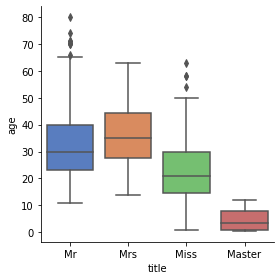

In [27]:
g = sns.catplot(x="title", y="age", data=data,
                height=4, kind="box", palette="muted")

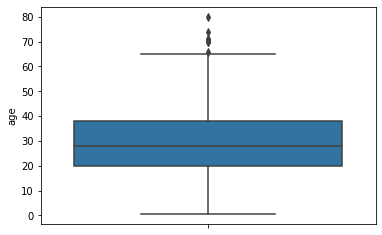

In [28]:
sns.boxplot(y = 'age', data = data)
plt.show()
# если заполнять пропуски в возрасте обшим средним

In [29]:
data.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title', 'surname'],
      dtype='object')

In [30]:
# на основе нескольких признаков
data['family'] = (data['sibsp'] + data['parch']).apply(lambda x : 1 if x>0 else 0)
data['fare_round'] = 20*(data['fare']//20)
l_col = ['pclass','sex','family','title','fare_round']
data['age'] = data['age'].fillna(data.groupby(l_col)['age'].transform('mean'))
# оставшиеся
data['age'] = data['age'].fillna(data.age.mean())

data = data.drop(columns = 'fare_round')

In [31]:
data[data.age.isnull()]

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family


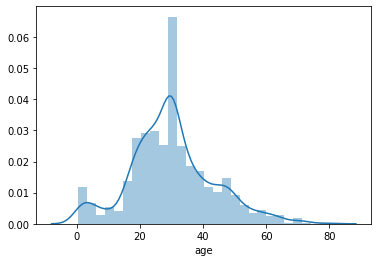

In [33]:
g = sns.distplot(data.age)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    int64  
 3   age       889 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   cabin     202 non-null    object 
 8   embarked  889 non-null    object 
 9   title     889 non-null    object 
 10  surname   889 non-null    object 
 11  family    889 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 130.3+ KB


In [35]:
col = [col for col in data.columns if ('port' not in col) and ('name' not in col)]
data[col].head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family
0,0,3,1,22.0,1,0,7.2500,NaN,S,Mr,1
1,1,1,0,38.0,1,0,71.2833,C85,C,Mrs,1
2,1,3,0,26.0,0,0,7.9250,NaN,S,Miss,0
3,1,1,0,35.0,1,0,53.1000,C123,S,Mrs,1
4,0,3,1,35.0,0,0,8.0500,NaN,S,Mr,0


проверить, если признаки 'pclass' и 'fare' зависимы \
ans.: не зависимы, можно оставить оба признака

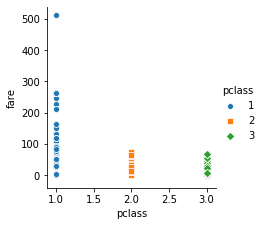

In [36]:
g = sns.pairplot(data, x_vars = 'pclass', y_vars = 'fare', hue = 'pclass', markers=["o", "s", "D"],\
                 height = 3, diag_kind = None)
plt.show()

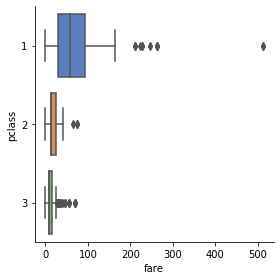

In [37]:
g = sns.catplot(y="pclass", x="fare", data=data, kind="box", palette="muted", orient ='h', height = 4)

# чем отличаются люди, которые выжили и которые утонули

In [38]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
748,0,1,1,19.0,1,0,53.1000,D30,S,Mr,Marvin,1
696,0,3,1,44.0,0,0,8.0500,NaN,S,Mr,Kelly,0
625,0,1,1,61.0,0,0,32.3208,D50,S,Mr,Sutton,0
606,0,3,1,30.0,0,0,7.8958,NaN,S,Mr,Karaic,0
437,1,2,0,24.0,2,3,18.7500,NaN,S,Mrs,Richards,1


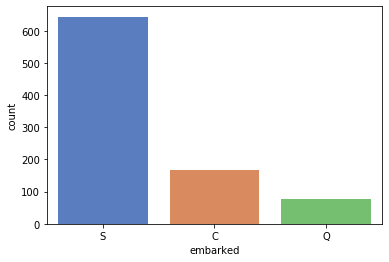

In [39]:
# признак embarked
g = sns.countplot(x = 'embarked', data = data, palette="muted")

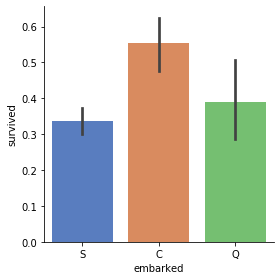

In [40]:
g = sns.catplot(x="embarked", y="survived", data=data,
                height=4, kind="bar", palette="muted")
# порт Cherbourg показывает больший процент выживших

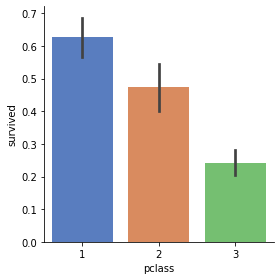

In [41]:
# класс билета
g = sns.catplot(x="pclass", y="survived", data=data,
                height=4, kind="bar", palette="muted")
# выживших в 1 классе больше

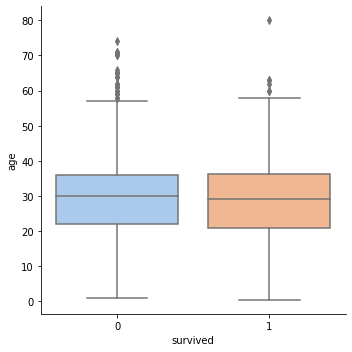

In [42]:
# возраст всех пассажиров
sns.catplot(x="survived", y="age", kind="box", data=data, palette="pastel");

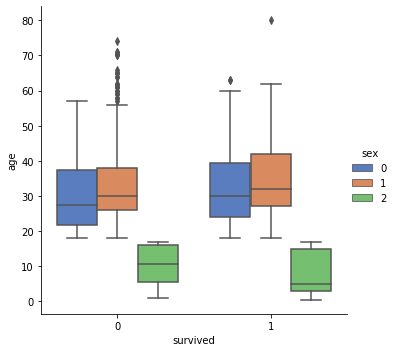

In [43]:
# с разделением по полу
sns.catplot(x="survived", y="age", hue ='sex', kind="box", data=data, palette="muted");
# выжившие женщины в среднем старше утонувших

In [44]:
# пол
women = data.loc[data.sex == 0]["survived"]
rate_women = sum(women)/len(women)

print("# of women who survived:", rate_women)

# of women who survived: 0.7509727626459144


In [45]:
men = data.loc[data.sex == 1]["survived"]
rate_men = sum(men)/len(men)

print("# of men who survived:", rate_men)

# of men who survived: 0.16570327552986513


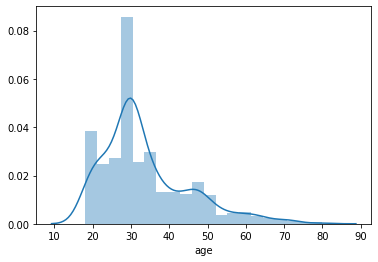

In [46]:
sns.distplot(data[data.sex == 1].age)
plt.show()
# мужчины

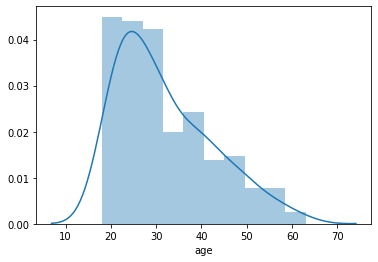

In [47]:
sns.distplot(data[data.sex == 0].age)
plt.show()
# женщины
# совсем старых нет

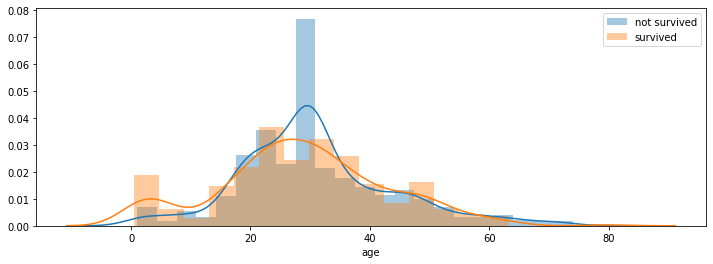

In [48]:
# зависит ли выживаемость от возраста
plt.figure(figsize = (12,4))
sns.distplot(data[data.survived == 0].age, label = 'not survived')
sns.distplot(data[data.survived == 1].age, label = 'survived')
plt.legend()
plt.show()

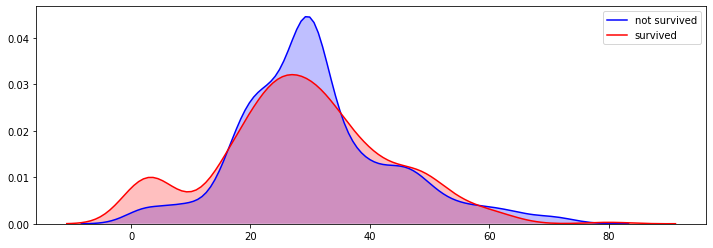

In [49]:
plt.figure(figsize = (12,4))
sns.kdeplot(data[data.survived == 0].age, label = 'not survived', color = 'b', shade = True)
sns.kdeplot(data[data.survived == 1].age, label = 'survived', color = 'red', shade = True)
plt.legend()
plt.show()
# до 18 лет - больше вероятность выжить
# от 18 до 35 лет - вероятность выжить небольшая
# после 35 лет - шансы примерно 50 на 50

поэтому для признака sex можно ввести категорию children (вверху)

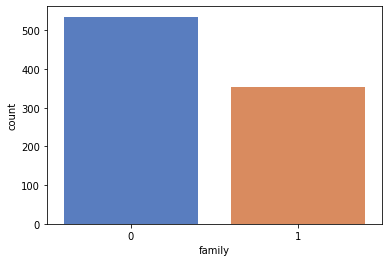

In [50]:
# наличие родственников на борту
g = sns.countplot(x = 'family', data = data, palette="muted")
plt.show()

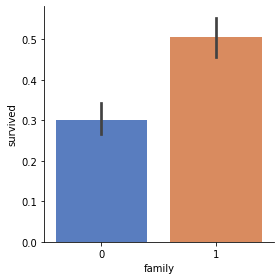

In [51]:
g = sns.catplot(x="family", y="survived", data=data,
                height=4, kind="bar", palette="muted")
# пассажиры с родственниками выжили в большем количестве 

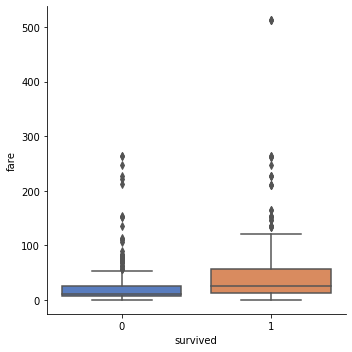

In [52]:
# плата за билет
sns.catplot(x="survived", y="fare", kind="box", data=data, palette="muted");
# у выживших плата за проезд существенно выше, чем у утонувших

# Список методов

`NON-TREE MODELS` \
**метрический** - метод ближайших соседей 

**линейный** - метод опорных векторов (только если линейно разделима выборка) \
**+** - для SVM сделать PCA \
**линейный** - логистическая регрессия 

`TREE MODELS` \
одно решающее дерево \
градиентный бустинг \
случайный лес

`OTHERS` \
нейронные сети
_______________
кросс-валидация на тесте

In [53]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
362,0,3,0,45.0,0,1,14.4542,NaN,C,Mrs,Barbara,1
13,0,3,1,39.0,1,5,31.2750,NaN,S,Mr,Andersson,1
164,0,3,2,1.0,4,1,39.6875,NaN,S,Master,Panula,1
92,0,1,1,46.0,1,0,61.1750,E31,S,Mr,Chaffee,1
20,0,2,1,35.0,0,0,26.0000,NaN,S,Mr,Fynney,0


# дерево решений (логический метод)

In [54]:
y = data['survived']
X = data.drop(['survived','surname'], axis=1)

In [55]:
X['fare_per_pers'] = (X['fare'] / (X['sibsp'] + X['parch']+ 1)).round(2)

In [56]:
X.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family,fare_per_pers
541,3,2,9.000000,4,2,31.2750,NaN,S,Miss,1,4.47
732,2,1,34.365385,0,0,0.0000,NaN,S,Mr,0,0.00
71,3,2,16.000000,5,2,46.9000,NaN,S,Miss,1,5.86
840,3,1,20.000000,0,0,7.9250,NaN,S,Mr,0,7.92
514,3,1,24.000000,0,0,7.4958,NaN,S,Mr,0,7.50


In [57]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         889 non-null    int64  
 1   sex            889 non-null    int64  
 2   age            889 non-null    float64
 3   sibsp          889 non-null    int64  
 4   parch          889 non-null    int64  
 5   fare           889 non-null    float64
 6   cabin          202 non-null    object 
 7   embarked       889 non-null    object 
 8   title          889 non-null    object 
 9   family         889 non-null    int64  
 10  fare_per_pers  889 non-null    float64
dtypes: float64(3), int64(5), object(3)
memory usage: 123.3+ KB


In [58]:
X.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [59]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
X.embarked = le.fit_transform(X.embarked)

# это label encoding для embarked
# вариант 1

In [60]:
# encoding = X.groupby('embarked').size()
# encoding = encoding/len(X)
# X['emb_enc'] = X.embarked.map(encoding)
# X.drop(['embarked'], axis = 1, inplace = True)

# это frequency encoding для embarked
# вариант 2

In [61]:
X.cabin.fillna('-', inplace = True)

In [62]:
X['cabin'] = X.cabin.apply(lambda x: x[0])

In [63]:
X.cabin.value_counts()

-    687
C     59
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin, dtype: int64

In [64]:
le = preprocessing.LabelEncoder()
X.cabin = le.fit_transform(X.cabin)
# это label encoding для cabin
# вариант 1

In [65]:
# encoding = X.groupby('cabin').size()
# encoding = encoding/len(X)
# X['cab_enc'] = X.cabin.map(encoding)
# X.drop(['cabin'], inplace = True, axis = 1)

# это frequency encoding для cabin
# вариант 2

In [66]:
le = preprocessing.LabelEncoder()
X.title = le.fit_transform(X.title)
# это label encoding для title
# вариант 1

In [67]:
# encoding = X.groupby('title').size() / len(X)
# X['tit_enc'] = X.title.map(encoding)
# X.drop(['title'], inplace = True, axis = 1)

# это frequency encoding для title
# вариант 2

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         889 non-null    int64  
 1   sex            889 non-null    int64  
 2   age            889 non-null    float64
 3   sibsp          889 non-null    int64  
 4   parch          889 non-null    int64  
 5   fare           889 non-null    float64
 6   cabin          889 non-null    int64  
 7   embarked       889 non-null    int64  
 8   title          889 non-null    int64  
 9   family         889 non-null    int64  
 10  fare_per_pers  889 non-null    float64
dtypes: float64(3), int64(8)
memory usage: 123.3 KB


In [69]:
X.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family,fare_per_pers
851,3,1,74.0,0,0,7.7750,0,2,2,0,7.78
259,2,0,50.0,0,1,26.0000,0,2,3,1,13.00
317,2,1,54.0,0,0,14.0000,0,2,3,0,14.00
424,3,1,18.0,1,1,20.2125,0,2,2,1,6.74
630,1,1,80.0,0,0,30.0000,1,2,2,0,30.00


In [70]:
from sklearn.tree import DecisionTreeClassifier

kf = KFold(n_splits = 5, random_state=42, shuffle=True)

for depth in [2,3,4,5]:
    model_tree = DecisionTreeClassifier(max_depth=depth)
    score = cross_val_score(model_tree, X = X, y = y, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('depth - {}, score - {}'.format(depth, score_norm))

depth - 2, score - 0.7918936075668126
depth - 3, score - 0.8245223132101822
depth - 4, score - 0.8155081571764109
depth - 5, score - 0.823411413698978


наилучший результат - 0.824

In [71]:
# from sklearn.tree import export_graphviz

In [72]:
# model_tree.fit(X,y)

In [73]:
# export_graphviz(model_tree, feature_names = ['pclass','sex','age','sibsp','parch','fare','cabin','amb_enc',\
#                                              'surname','family_size', 'fare_per_pers', 'tit_enc'], out_file = 'tree.dot', filled = True)

# случайный лес

In [74]:
from sklearn.ensemble import RandomForestClassifier

score_ar = np.array([])
estim = [10,20,30,40,50,80,100,150]
for k in estim:
    #     обратить внимание на max_features, max_samples
    clf_rf = RandomForestClassifier(n_estimators = k, random_state = 1, max_samples = 0.4)
    score = cross_val_score(clf_rf, X = X, y = y, cv = kf, scoring ='accuracy')
    score_norm = np.mean(score, axis=0)
    score_ar = np.append(score_ar,score_norm)
k_optimal = np.argmax(score_ar)
print (estim[k_optimal])
print(score_ar[k_optimal])

150
0.8188852916904716


# градиентный бустинг

In [75]:
# работает быстро, ограничений на глубину не требуется
# масштабирование тоже не требуется
from sklearn.ensemble import GradientBoostingClassifier

score_ar = np.array([])
estim = [10,20,30,40,50,80,100,150]
for k in estim:
    #     обратить внимание на max_features и подвыборку объектов (subsample)
    clf = GradientBoostingClassifier(n_estimators=k, random_state=241, subsample = 1.0)
    score = cross_val_score(clf, X = X, y = y, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    score_ar = np.append(score_ar,score_norm)
k_optimal = np.argmax(score_ar)
print('k - {}, score - {}'.format(estim[k_optimal], score_ar[k_optimal]))

k - 80, score - 0.8402716942804546


In [76]:
X.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family,fare_per_pers
399,2,0,28.0,0,0,12.6500,0,2,3,0,12.65
528,3,1,39.0,0,0,7.9250,0,2,2,0,7.92
16,3,2,2.0,4,1,29.1250,0,1,0,1,4.85
317,2,1,54.0,0,0,14.0000,0,2,3,0,14.00
628,3,1,26.0,0,0,7.8958,0,2,2,0,7.90


# ближайшие соседи (метрический метод)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    int64  
 3   age       889 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   cabin     202 non-null    object 
 8   embarked  889 non-null    object 
 9   title     889 non-null    object 
 10  surname   889 non-null    object 
 11  family    889 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 130.3+ KB


In [78]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
407,1,2,2,3.0,1,1,18.7500,NaN,S,Master,Richards,1
99,0,2,1,34.0,1,0,26.0000,NaN,S,Mr,Kantor,1
91,0,3,1,20.0,0,0,7.8542,NaN,S,Mr,Andreasson,0
356,1,1,0,22.0,0,1,55.0000,E33,S,Miss,Bowerman,1
124,0,1,1,54.0,0,1,77.2875,D26,S,Mr,White,1


In [79]:
yl = data['survived']
Xl = data.drop(['survived', 'surname'], axis = 1)

In [80]:
Xl['fare_per_pers'] = Xl['fare'] / (Xl['sibsp'] + Xl['parch'] + 1)

In [81]:
Xl.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family,fare_per_pers
319,1,0,40.0,1,1,134.5000,E34,C,Mrs,1,44.833333
665,2,1,32.0,2,0,73.5000,NaN,S,Mr,1,24.500000
227,3,1,20.5,0,0,7.2500,NaN,S,Mr,0,7.250000
704,3,1,26.0,1,0,7.8542,NaN,S,Mr,1,3.927100
512,1,1,36.0,0,0,26.2875,E25,S,Mr,0,26.287500


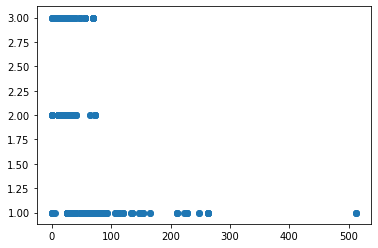

In [82]:
plt.scatter(Xl.fare, Xl.pclass);

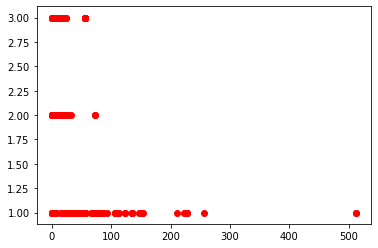

In [83]:
plt.scatter(Xl.fare_per_pers, Xl.pclass, c= 'r');

In [84]:
Xl = Xl.join(pd.get_dummies(Xl.embarked, prefix='port')).drop(['embarked'], axis = 1)
Xl = Xl.join(pd.get_dummies(Xl.title, prefix='title')).drop(['title'], axis = 1)

In [85]:
Xl.cabin.fillna('-', inplace = True)
Xl['cabin'] = Xl.cabin.apply(lambda x: x[0])

In [86]:
Xl.cabin.value_counts()

-    687
C     59
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin, dtype: int64

In [87]:
Xl = Xl.join(pd.get_dummies(Xl.cabin, prefix='cabin')).drop(['cabin'], axis = 1)

In [88]:
Xl.sample(5)

,pclass,sex,age,sibsp,parch,fare,family,fare_per_pers,port_C,port_Q,...,title_Mrs,cabin_-,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T
481,2,1,34.365385,0,0,0.0000,0,0.000000,0,0,...,0,1,0,0,0,0,0,0,0,0
165,3,2,9.000000,0,2,20.5250,1,6.841667,0,0,...,0,1,0,0,0,0,0,0,0,0
326,3,1,61.000000,0,0,6.2375,0,6.237500,0,0,...,0,1,0,0,0,0,0,0,0,0
6,1,1,54.000000,0,0,51.8625,0,51.862500,0,0,...,0,0,0,0,0,0,1,0,0,0
211,2,0,35.000000,0,0,21.0000,0,21.000000,0,0,...,0,1,0,0,0,0,0,0,0,0


In [89]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
418,0,2,1,30.0,0,0,13.0000,NaN,S,Mr,Matthews,0
399,1,2,0,28.0,0,0,12.6500,NaN,S,Mrs,Trout,0
588,0,3,1,22.0,0,0,8.0500,NaN,S,Mr,Gilinski,0
256,1,1,0,24.0,0,0,79.2000,NaN,C,Mrs,Thorne,0
371,0,3,1,18.0,1,0,6.4958,NaN,S,Mr,Wiklund,1


In [90]:
from sklearn.neighbors import KNeighborsClassifier

In [91]:
kf = KFold(n_splits = 5, random_state=42, shuffle=True)

In [92]:
# без масштбаирования результат плохой
score_ar = np.array([])
for k in range(1,51):
    k_classifier = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(k_classifier, X=Xl, y=yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis = 0)
    score_ar = np.append(score_ar, score_norm)
k_optimal = np.argmax(score_ar)+1
print('k - {}, score - {}'.format(k_optimal, score_ar[k_optimal-1]))

k - 12, score - 0.7401574303307307


In [93]:
# с масштабирвоанием результат лучше
from sklearn.preprocessing import scale 
scaled_Xl = scale(Xl)

score_ar = np.array([])
for k in range(1,51):
    k_classifier = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(k_classifier, X = scaled_Xl, y=yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0) #or average
    score_ar = np.append(score_ar, score_norm)
k_optimal = np.argmax(score_ar)+1
print (k_optimal)
print('k - {}, score - {}'.format(k_optimal, score_ar[k_optimal-1]))

18
k - 18, score - 0.8222624262045326


# логистическая регрессия (линейный метод)

### c PCA(метод главных компонент)

In [94]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(scaled_Xl)

pca.n_components_

17

In [95]:
scaled_Xl_pca = pca.transform(scaled_Xl)

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

for c in np.logspace(-2,2, num = 5):
    clf_lr = LogisticRegression(C = c, random_state = 241)
    score = cross_val_score(clf_lr, X = scaled_Xl_pca, y = yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('c - {}, score - {}'.format(c, score_norm))

c - 0.01, score - 0.8065130451342603
c - 0.1, score - 0.8199834952072621
c - 1.0, score - 0.8222370342157049
c - 10.0, score - 0.821113438710087
c - 100.0, score - 0.8233606297213228


лучший результат - 0.82

### без PCA

In [97]:
for c in np.logspace(-2,2, num = 5):
    clf_lr = LogisticRegression(C = c, random_state = 241)
    score = cross_val_score(clf_lr, X = scaled_Xl, y = yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('c - {}, score - {}'.format(c, score_norm))

c - 0.01, score - 0.8143718656763792
c - 0.1, score - 0.8188535517044372
c - 1.0, score - 0.8233415857297024
c - 10.0, score - 0.8233415857297024
c - 100.0, score - 0.8233415857297024


лучший результат - 0.82

# метод опорных векторов (линейный метод)

In [98]:
from sklearn.svm import SVC

for c in np.logspace(-2,1,num=4):
    clf_svm = SVC(C = c, random_state=241, kernel='rbf')
    score = cross_val_score(clf_svm, X = scaled_Xl, y = yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('c - {}, score - {}'.format(c, score_norm))

c - 0.01, score - 0.6175903002602678
c - 0.1, score - 0.7738208595188218
c - 1.0, score - 0.8301148987494444
c - 10.0, score - 0.824528661207389


лучший результат - 0.83

# перспетрон (нейронные сети)

In [101]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split

Xl_train, Xl_test, yl_train, yl_test = train_test_split(scaled_Xl, yl, test_size=0.33, random_state=42)

clf_nn = Perceptron(random_state=241, shuffle = True, max_iter=2000, tol=None)
clf_nn.fit(Xl_train, yl_train)
predictions = clf_nn.predict(Xl_test)
print(accuracy_score(yl_test, predictions))

0.7925170068027211


# проверка на тесте
### подготовка данных

In [102]:
data_test = pd.read_csv('test_titanic.csv')
data_test.columns = data_test.columns.str.lower()

In [103]:
data_test.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [104]:
X_test = data_test.drop(columns = ['ticket'])
X_test['title'] = X_test.name.apply(lambda x: x.split(', ')[1].split()[0].replace('.',''))
X_test.title = X_test.apply(replace_titles, axis = 1)
X_test['sex'].replace({'female':0,'male':1}, inplace=True)
X_test['fare'].fillna(X_test.fare.mean(), inplace = True)
X_test['fare_per_pers'] = X_test['fare'] / (X_test['sibsp'] + X_test['parch'] + 1)

In [107]:
X_test['sex'].loc[X_test['age']<18] = 2

In [108]:
le = preprocessing.LabelEncoder()
X_test.embarked = le.fit_transform(X_test.embarked)

# label encoding для embarked

In [109]:
X_test = X_test.drop(['name', 'passengerid'], axis = 1)

In [110]:
X_test.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,fare_per_pers
272,1,0,26.0,1,0,136.7792,C89,0,Mrs,68.3896
265,3,1,NaN,0,0,7.8958,NaN,2,Mr,7.8958
170,3,1,NaN,0,0,7.5500,NaN,2,Mr,7.5500
135,3,1,24.0,0,0,7.8542,NaN,2,Mr,7.8542
246,2,0,22.0,0,0,21.0000,NaN,2,Mrs,21.0000


In [111]:
# восстанавливаем возраст
X_test['family'] = (X_test['sibsp'] + X_test['parch']).apply(lambda x : 1 if x>0 else 0)
X_test['fare_round'] = 20*(X_test['fare']//20)
l_col = ['pclass','sex','family','title','fare_round']
X_test['age'] = X_test['age'].fillna(X_test.groupby(l_col)['age'].transform('mean'))
# оставшиеся
X_test['age'] = X_test['age'].fillna(X_test.age.mean())

X_test = X_test.drop(columns = 'fare_round')

In [112]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         418 non-null    int64  
 1   sex            418 non-null    int64  
 2   age            418 non-null    float64
 3   sibsp          418 non-null    int64  
 4   parch          418 non-null    int64  
 5   fare           418 non-null    float64
 6   cabin          91 non-null     object 
 7   embarked       418 non-null    int64  
 8   title          418 non-null    object 
 9   fare_per_pers  418 non-null    float64
 10  family         418 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 36.0+ KB


In [113]:
X_test.cabin.fillna('-', inplace = True)
X_test['cabin'] = X_test.cabin.apply(lambda x: x[0])

In [114]:
le = preprocessing.LabelEncoder()
X_test.cabin = le.fit_transform(X_test.cabin)
# # это label encoding для cabin


# encoding = X_test.groupby('cabin').size()
# # get frequency of each category
# encoding = encoding/len(X_test)
# X_test['cab_enc'] = X_test.cabin.map(encoding)
# X_test.drop(['cabin'], inplace = True, axis = 1)

# это frequency encoding для cabin

In [115]:
le = preprocessing.LabelEncoder()
X_test.title = le.fit_transform(X_test.title)

# это label encoding для title

In [116]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         418 non-null    int64  
 1   sex            418 non-null    int64  
 2   age            418 non-null    float64
 3   sibsp          418 non-null    int64  
 4   parch          418 non-null    int64  
 5   fare           418 non-null    float64
 6   cabin          418 non-null    int64  
 7   embarked       418 non-null    int64  
 8   title          418 non-null    int64  
 9   fare_per_pers  418 non-null    float64
 10  family         418 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 36.0 KB


### выбор лучшей модели

In [117]:
# пусть градиентный бустинг
clf = GradientBoostingClassifier(n_estimators=80, random_state=241)
clf.fit(X, y)
y_predict = clf.predict(X_test)

In [118]:
d = {'PassengerId':data_test['passengerid'], 'Survived':y_predict}
df = pd.DataFrame(data = d)
df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [119]:
df.to_csv('TITANIC_result', index = False)

In [120]:
len(df)

418

# RESULT - 0.79425
модель - градиентный бустинг \
для фамилии и кабины использовался label encoding